In [1]:
from experiments.experiments import train, evaluate
from experiments.utils import *
from agent.agents import *
from agent.switching_agents import *
from environments.env import * 
from definitions import ROOT_DIR
from plot.plot_regret import plot_performance

from torch.optim import *
import numpy as np
import random 
import torch
import pickle
from copy import deepcopy
import pandas as pd


np.random.seed(12345678)
random.seed(12345678)
torch.manual_seed(12345678)


## Train baselines and 2-stage algorithm

### Configure Environment

In [2]:
env_generator = Environment()
width = 3
height = 20
depth = height//3
init_traffic_level = 'light'
env_params = {'width' : width, 'height':height, 'init_traffic_level': init_traffic_level, 'depth': depth}
env_generator_fn = lambda:env_generator.generate_grid_world(**env_params)
n_actions = 3

### Configure Agents

In [3]:
# Human 
estimation_noise = 0.2
switching_noise = 0.0
c_H = 0.0

# Machine
batch_size = 1
# state size with string features
n_state_features_strings = env_generator.n_state_strings(depth, width)

# define state size in 1-hot encoding
n_state_features_1hot =  env_generator.n_state_one_hot(depth, width)

n_state_features = (n_state_features_strings, n_state_features_1hot)

c_M = 0.2
lr = 1e-4
optimizer_fn = lambda params: RMSprop(params, lr)

# Switching Agent
def eps_fn(timestep):
    if (timestep//20) < 25000:
        epsilon = 0.5
    elif (timestep//20) < 50000:
        epsilon = 0.1
    else:
        epsilon = 0.1* 1 / sqrt(timestep - 50000*20+1)
    return epsilon
epsilon = eps_fn

### Initialize Agents

In [4]:
human  = NoisyDriverAgent(env_generator, prob_wrong=estimation_noise, noise_sw=switching_noise, c_H=c_H)
human_perf = NoisyDriverAgent(env_generator, prob_wrong=0.0, noise_sw=switching_noise, c_H=c_H)

machine = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=c_M, entropy_weight = 0.0, batch_size=batch_size)

machine_only = FixedSwitchingMachine(n_state_features, optimizer_fn, c_M=c_M, batch_size=batch_size)

human_only = FixedSwitchingHuman()

switch_fixed_policies = SwitchingAgent(n_state_features, optimizer_fn, c_M=c_M, c_H=c_H, eps_fn=epsilon)

# same initialisation
switch_full = SwitchingAgent(n_state_features, optimizer_fn, c_M=c_M, c_H=c_H, eps_fn=epsilon, batch_size=batch_size)
# must be deepcopy of machine before training
switch_machine = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=c_M,entropy_weight = 0.01, batch_size=batch_size)


### Train Steps

In [5]:
n_traj = 10000
n_episodes = 50000

### Gather human traces

In [6]:
%%time
# gather human trajectories
# trajectories = gather_human_trajectories(human, env_generator, n_traj,**env_params)
# # save for later
# with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_pureState', 'wb') as file:
#     pickle.dump(trajectories, file, pickle.HIGHEST_PROTOCOL)
# with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent_pureState', 'wb') as file:
#     pickle.dump(human, file, pickle.HIGHEST_PROTOCOL)
    

Wall time: 0 ns


In [7]:

with open(f'{ROOT_DIR}/outputs/trajectories/human2_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_pureState', 'rb') as file:
    trajectories = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/trajectories/human2_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent_pureState', 'rb') as file:
    human = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/on_line_set_{n_episodes}_{init_traffic_level}', 'rb') as file:
    on_line_set = pickle.load(file)
# with open(f'{ROOT_DIR}/outputs/results/auto_b1_We_off_D50K_on_D50K_h3.5/actor_agent_off', 'rb') as file:
#     machine = pickle.load(file)

### Evaluation Parametes

In [6]:
n_eval_set_size = (n_traj + n_episodes)//10
eval_freq = 1000//batch_size
save_freq = 1000000
# eval_set = [ env_generator_fn() for i in range(n_eval_set_size)]
with open(f'{ROOT_DIR}/outputs/eval_set', 'rb') as file:
    eval_set = pickle.load(file)

In [21]:
for i in range(10):
    if sum(human.policy_approximation[i, ('road', 'road', 'road', 'stone', 'car', 'road', 'grass', 'road', 'road', 'road', 'road', 'stone', 'road', 'grass', 'road', 'road', 'road', 'road', 'road')]):
        print(i)


0


### Training

In [10]:
# machine.trainable = False
machine_only_algo = {'machine': (machine_only, [human, machine])}
machine_only_algo, machine_only_costs = train(machine_only_algo, trajectories[:10000], [], eval_set, eval_freq, save_freq, batch_size=1)

0 ['road', 'road', 'road', 'stone', 'car', 'road', 'grass', 'road', 'road', 'road', 'road', 'stone', 'road', 'grass', 'road', 'road', 'road', 'road', 'road']
0 ['road', 'car', 'road', 'grass', 'road', 'road', 'road', 'road', 'stone', 'road', 'grass', 'road', 'road', 'road', 'road', 'road', 'stone', 'road', 'road']
0 ['car', 'wall', 'road', 'road', 'road', 'stone', 'road', 'grass', 'road', 'road', 'road', 'road', 'road', 'stone', 'road', 'road', 'road', 'road', 'stone']
0 ['road', 'road', 'stone', 'road', 'grass', 'road', 'road', 'road', 'road', 'road', 'stone', 'road', 'road', 'road', 'road', 'stone', 'road', 'grass', 'grass']
0 ['road', 'road', 'road', 'wall', 'road', 'road', 'road', 'stone', 'road', 'road', 'road', 'road', 'stone', 'road', 'grass', 'grass', 'road', 'road', 'road']
0 ['road', 'road', 'road', 'road', 'stone', 'road', 'road', 'road', 'road', 'stone', 'road', 'grass', 'grass', 'road', 'road', 'road', 'grass', 'grass', 'road']
0 ['road', 'road', 'road', 'wall', 'road', 'r

ZeroDivisionError: division by zero

In [11]:
evaluate(switch_fixed_policies, [human, machine], eval_set, 1)

(13.403399999999998, 0.49855)

In [ ]:
machine_only_algo, machine_only_costs = train(machine_only_algo, trajectories[10000:20000], [], eval_set, eval_freq, save_freq, batch_size=1)

In [6]:
human_cost = evaluate(human_only, [human], eval_set)
print(human_cost)

10.402


In [9]:
# machine.trainable = False
algos = {'switch': (switch_full,[human, switch_machine])}
algos, algos_costs = train(algos, trajectories[:6000],[], eval_set, eval_freq, save_freq)

2021-06-04 13:21:11.916290, Off-policy, Episode 1000, switch evaluation cost: 14.212
0.0
2021-06-04 13:27:40.817534, Off-policy, Episode 2000, switch evaluation cost: 14.27
0.0
2021-06-04 13:34:58.346559, Off-policy, Episode 3000, switch evaluation cost: 14.178
0.0
2021-06-04 13:41:51.167171, Off-policy, Episode 4000, switch evaluation cost: 14.242
0.0
2021-06-04 13:48:41.020613, Off-policy, Episode 5000, switch evaluation cost: 14.198
0.0
2021-06-04 13:55:31.260077, Off-policy, Episode 6000, switch evaluation cost: 14.196
0.0


In [10]:
algos, algos_costs = train(algos, trajectories[6000:20000],[], eval_set, eval_freq, save_freq)

2021-06-04 14:02:12.277014, Off-policy, Episode 1000, switch evaluation cost: 14.144
0.0
Deltas 
actor zero grad
2021-06-04 14:08:47.357612, Off-policy, Episode 2000, switch evaluation cost: 14.152
0.0
2021-06-04 14:15:28.718568, Off-policy, Episode 3000, switch evaluation cost: 14.298
0.0
2021-06-04 14:21:56.993776, Off-policy, Episode 4000, switch evaluation cost: 14.282
0.0
2021-06-04 14:28:36.632634, Off-policy, Episode 5000, switch evaluation cost: 14.488
0.0
2021-06-04 14:35:18.424615, Off-policy, Episode 6000, switch evaluation cost: 14.208
0.0
2021-06-04 14:41:54.698281, Off-policy, Episode 7000, switch evaluation cost: 14.004
0.0
2021-06-04 14:48:36.861283, Off-policy, Episode 8000, switch evaluation cost: 14.498
0.0
2021-06-04 14:55:17.631206, Off-policy, Episode 9000, switch evaluation cost: 13.998
0.0
2021-06-04 15:01:59.258178, Off-policy, Episode 10000, switch evaluation cost: 13.992
0.0


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\user\\Desktop\\Project_SWS\\code\\experiments-source-code\\human-machine-switching/results/switch/switching_agent_off'

In [8]:
%%time

machine.trainable = False
algos = {'fixed_policies': (switch_fixed_policies,[human, machine]), 'switching':( switch_full,[human, switch_machine]) }

algos, algos_costs = train(algos, [], env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)


2021-05-24 11:14:19.513437, On-policy, Episode 200, fixed_policies  evaluation cost: 12.0094
2021-05-24 11:15:06.223108, On-policy, Episode 200, switching  evaluation cost: 12.022
2021-05-24 11:17:11.290262, On-policy, Episode 400, fixed_policies  evaluation cost: 11.919599999999999
2021-05-24 11:17:59.017992, On-policy, Episode 400, switching  evaluation cost: 11.916599999999999
2021-05-24 11:20:06.435279, On-policy, Episode 600, fixed_policies  evaluation cost: 12.192599999999999
2021-05-24 11:20:53.513972, On-policy, Episode 600, switching  evaluation cost: 11.605399999999998
2021-05-24 11:23:01.026265, On-policy, Episode 800, fixed_policies  evaluation cost: 12.0216
2021-05-24 11:23:49.154018, On-policy, Episode 800, switching  evaluation cost: 11.878
2021-05-24 11:25:59.211457, On-policy, Episode 1000, fixed_policies  evaluation cost: 11.9902
2021-05-24 11:26:48.158257, On-policy, Episode 1000, switching  evaluation cost: 11.787799999999999
Wall time: 14min 40s


## Evaluate Performance

In [2]:
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_50000_agent', 'rb') as file:
    human = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_cost', 'rb') as file :
    human_cost = pickle.load (file)
with open(f'{ROOT_DIR}/outputs/eval_set', 'rb') as file:
    eval_set = pickle.load(file)

algos = {'human_only': [human_cost]*30}
for agent in ['machine_online_entorpy_weight_decay','pre_trained_machine_online', 'pre_trained_machine','fixed_policies','switching', 'machine_rnd_human', 'switching_batched','switching_eval_exp']:
    # with open(f'{ROOT_DIR}/outputs/agents/{agent}/costs_off', 'rb') as file:
    #     off = pickle.load(file)
    #     print(off[-1])
    #     algos[agent] = off
    with open(f'{ROOT_DIR}/outputs/agents/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        print(len(on))
        algos[agent]= on



NameError: name 'estimation_noise' is not defined

In [17]:
gd_vs_rnd_human = {'human':[evaluate(human_only, [human], eval_set, n_try=1) for _ in range(50)]}


In [18]:
agents = ['fxd_b1_We_off_D50K_on_D50K_eps_e3', 'switch_b1_We_off_D50K_on_D50K_eps_e3']
sw_agents ={}
for agent in agents:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_off', 'rb') as file:
        off = pickle.load(file)
        sw_agents[agent] = off
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        sw_agents[agent].extend(on)


In [20]:
sw_agents_df = pd.DataFrame(sw_agents)


<AxesSubplot:>

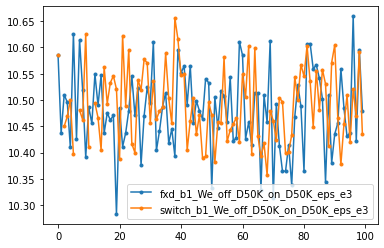

In [21]:
sw_agents_df[sw_agents_df < 12.].plot(style='.-')

In [19]:
gd_vs_rnd_human['optimal'] = [8.372]* 50

<AxesSubplot:title={'center':'Batch = 5 w/ entropy weight decay'}>

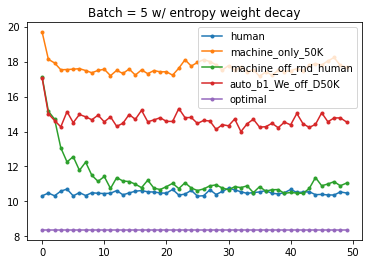

In [20]:
df_gd_vs_rnd_human = pd.DataFrame(gd_vs_rnd_human)
# df_gd_vs_rnd_human['steps'] = [i*5 for i in range(200, 10001,200)]
df_gd_vs_rnd_human.plot( style='.-', title='Batch = 5 w/ entropy weight decay')

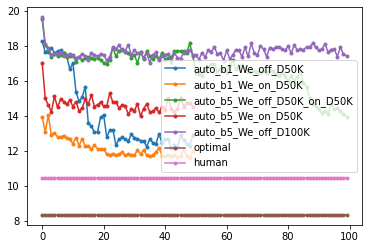

In [11]:
root_dir = f'{ROOT_DIR}/outputs/agents/ent_batched'
agents = ['auto_b1_We_off_D50K','auto_b1_We_on_D50K','auto_b5_We_off_D50K_on_D50K', 'auto_b5_We_on_D50K', 'auto_b5_We_off_D100K']
plot_performance(root_dir, eval_set, agents, 8.372, human_c=10.5  )

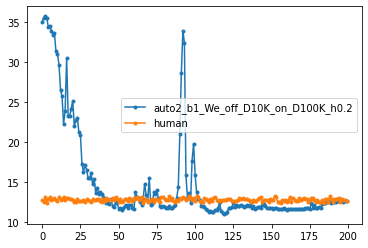

In [12]:
setting = 2
with open(f'{ROOT_DIR}/outputs/trajectories/human{setting}_0.2_{switching_noise}_{init_traffic_level}_trajectories_10000_agent_pureState', 'rb') as file:
        human = pickle.load(file)
        root_dir = f'{ROOT_DIR}/results/'
        agents = [f'auto{setting}_b1_We_off_D10K_on_D100K_h0.2']
        df = plot_performance(root_dir,eval_set, agents, human_cost_flat = False, human=human)

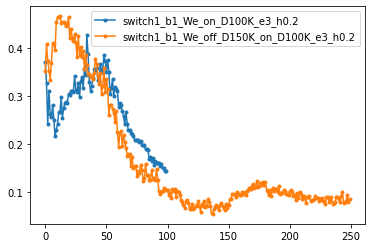

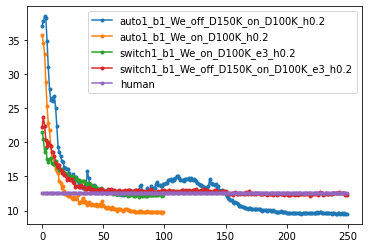

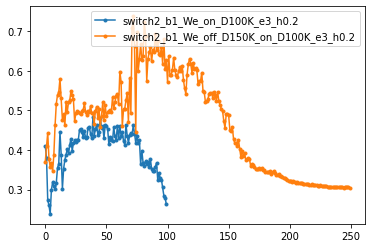

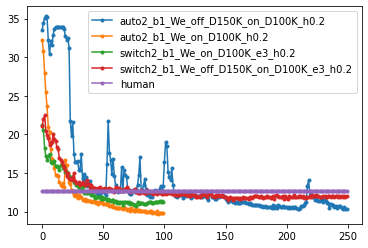

In [9]:
for setting in [1,2]:    
    with open(f'{ROOT_DIR}/outputs/trajectories/human{setting}_0.2_{switching_noise}_{init_traffic_level}_trajectories_150000_agent_pureState', 'rb') as file:
        human = pickle.load(file)
        root_dir = f'{ROOT_DIR}/outputs/results/'
        agents = [f'auto{setting}_b1_We_off_D150K_on_D100K_h0.2',\
                  f'auto{setting}_b1_We_on_D100K_h0.2',\
                  f'switch{setting}_b1_We_on_D100K_e3_h0.2',\
                  f'switch{setting}_b1_We_off_D150K_on_D100K_e3_h0.2']
        df = plot_performance(root_dir,eval_set, agents, human=human)

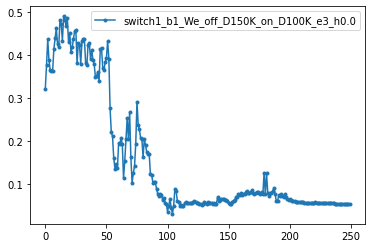

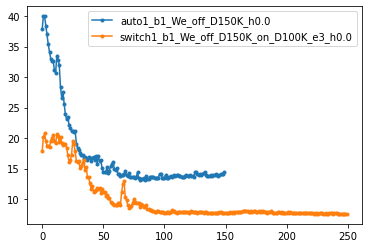

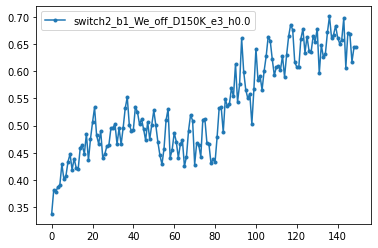

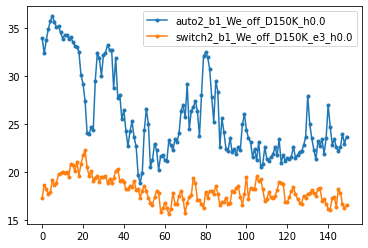

In [7]:
for setting in [1,2]:  
    root_dir = f'{ROOT_DIR}/outputs/results/'
    agents = [f'auto{setting}_b1_We_off_D150K_h0.0']
    if setting==1:
        agents.append(f'switch{setting}_b1_We_off_D150K_on_D100K_e3_h0.0')
    else:
        agents.append(f'switch{setting}_b1_We_off_D150K_e3_h0.0')

    df = plot_performance(root_dir,eval_set, agents, human=None)

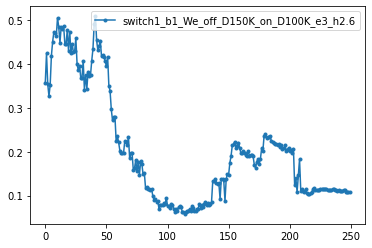

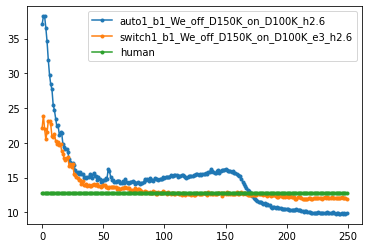

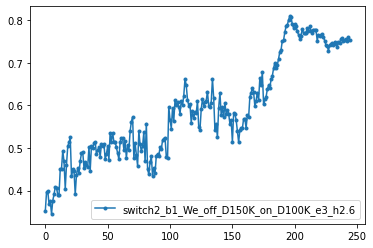

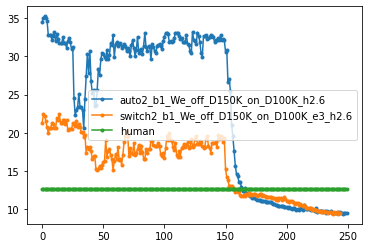

In [103]:
for setting in [1,2]:    
    with open(f'{ROOT_DIR}/outputs/trajectories/human{setting}_2.6_{switching_noise}_{init_traffic_level}_trajectories_150000_agent_pureState', 'rb') as file:
        human = pickle.load(file)
        root_dir = f'{ROOT_DIR}/outputs/results/'
        agents = [f'auto{setting}_b1_We_off_D150K_on_D100K_h2.6',f'switch{setting}_b1_We_off_D150K_on_D100K_e3_h2.6']
        df = plot_performance(root_dir,eval_set, agents, human=human)

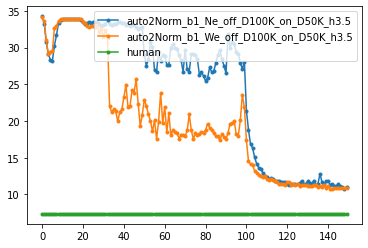

In [23]:
root_dir = f'{ROOT_DIR}/outputs/results/'
agents = ['auto2Norm_b1_Ne_off_D100K_on_D50K_h3.5', 'auto2Norm_b1_We_off_D100K_on_D50K_h3.5',]
df = plot_performance(root_dir,eval_set, agents, human=human)

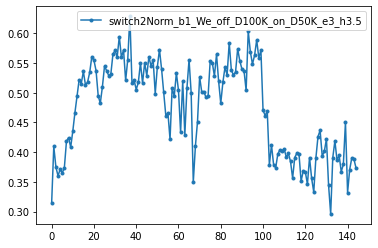

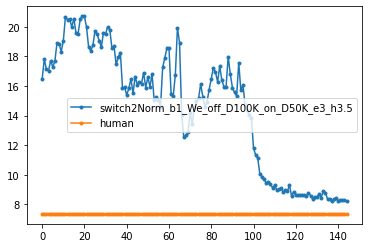

In [25]:
root_dir = f'{ROOT_DIR}/outputs/results/'
agents = [ 'switch2Norm_b1_We_off_D100K_on_D50K_e3_h3.5',]
df = plot_performance(root_dir,eval_set, agents, human=human)

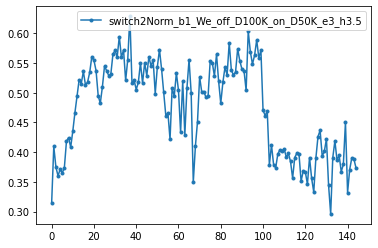

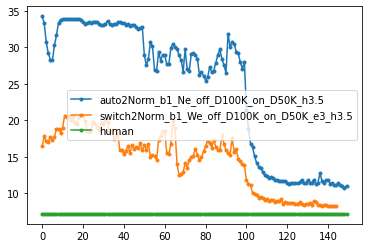

In [21]:
root_dir = f'{ROOT_DIR}/outputs/results/'
agents = ['auto2Norm_b1_Ne_off_D100K_on_D50K_h3.5', 'auto2Norm_b1_Ne_off_D100K_on_D50K_h3.5','switch2Norm_b1_We_off_D100K_on_D50K_e3_h3.5','switch2Norm_b1_We_off_D100K_on_D50K_e3_h3.5' ]
df = plot_performance(root_dir,eval_set, agents, human=human)

In [15]:
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent_pureState', 'rb') as file:
    human = pickle.load(file)

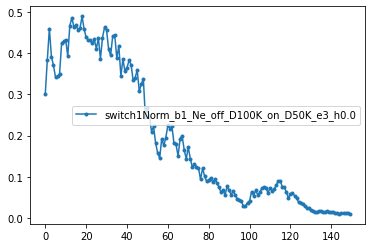

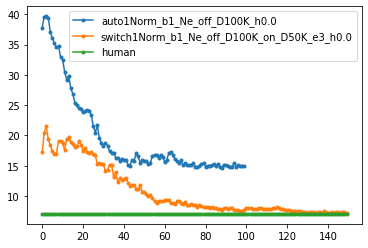

In [17]:
root_dir = f'{ROOT_DIR}/outputs/results/'
agents = ['auto1Norm_b1_Ne_off_D100K_h0.0','switch1Norm_b1_Ne_off_D100K_on_D50K_e3_h0.0' ]
df = plot_performance(root_dir,eval_set, agents, human=human)

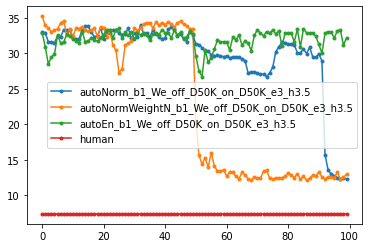

In [9]:
agents = [f'{agent}_b1_We_off_D50K_on_D50K_e3_h3.5' for agent in [ 'autoNorm', 'autoNormWeightN','autoEn']]
df = plot_performance(root_dir,eval_set, agents, human=human)

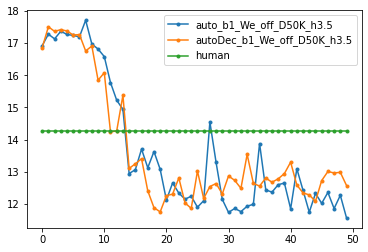

In [12]:
root_dir = f'{ROOT_DIR}/outputs/results/'
agents = ['auto_b1_We_off_D50K_h3.5','autoDec_b1_We_off_D50K_h3.5' ]
df_auto = plot_performance(root_dir,eval_set, agents, human=human)

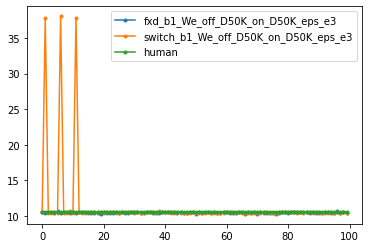

In [12]:
root_dir = f'{ROOT_DIR}/outputs/agents/ent_batched'
agents = ['fxd_b1_We_off_D50K_on_D50K_eps_e3', 'switch_b1_We_off_D50K_on_D50K_eps_e3']
plot_performance(root_dir,eval_set, agents, None, human_c=10.5)

In [9]:
fxd_p_vs_sw_offline = {}
for agent in [ 'fixed_policies_50K_eval3_b5', 'switch_b5_We_off_D50K_e3','fxd_b5_We_off_D50K_on_D50K','fxd_b1_We_off_D50K_on_D50K_eps_e3']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_off', 'rb') as file:
        off = pickle.load(file)
        fxd_p_vs_sw_offline[agent] = off
# fxd_p_vs_sw_offline['human'] = gd_vs_rnd_human['human']
# fxd_p_vs_sw_offline['optimal'] = gd_vs_rnd_human['optimal']
df_fxd_p_sw = pd.DataFrame(fxd_p_vs_sw_offline)
# df_fxd_p_sw['steps'] = df_gd_vs_rnd_human['steps']


<AxesSubplot:title={'center':'Batch 5, w/ entropy weight decay'}>

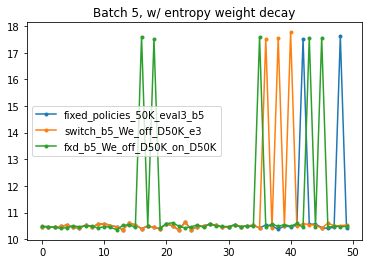

In [16]:
df_fxd_p_sw.plot(style='.-',  title='Batch 5, w/ entropy weight decay')

In [30]:
algos_75K = {'human_only':[human_cost]*75}
for agent in ['machine_only_75K', 'fixed_policies_75K', 'switching_75K']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        algos_75K[agent]= on

algos_100K = {'human_only':[human_cost]*100, 'optimal':[8.372]*100,'machine_online_100K':[], 'machine_only_50K_on_after_off':[] }
with open(f'{ROOT_DIR}/outputs/agents/ent_batched/machine_only_75K/costs_off', 'rb') as file:
    off = pickle.load(file)
    algos_100K['machine_only_50K_on_after_off'].extend(off)

for agent in ['machine_online_100K', 'machine_only_50K_on_after_off']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        algos_100K[agent].extend(on)


In [23]:
algos_50K = {'human_only':[human_cost]*100, 'optimal':[8.372]*100}
for agent in ['machine_only', 'fixed_policies','switching']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}_50k-50k/costs_off', 'rb') as file:
        off = pickle.load(file)
        print(len(off))
        algos_50K[agent]= off
for agent in ['machine_only', 'fixed_policies','switching']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}_50k-50k/costs_on', 'rb') as file:
        on = pickle.load(file)
        print(len(on))
        algos_50K[agent].extend(on)
algos_50K['fixed_policies'] = algos_50K['fixed_policies'][-100:] 

50
50
50
50
100
50


<AxesSubplot:>

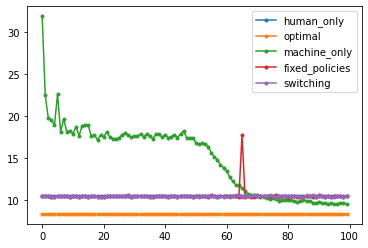

In [24]:

df_50k = pd.DataFrame(algos_50K)
df_50k.plot(style='.-')

In [ ]:
df_50k[df_50k<12][[ 'fixed_policies', 'switching', 'human_only']].plot(style='.-')

<AxesSubplot:>

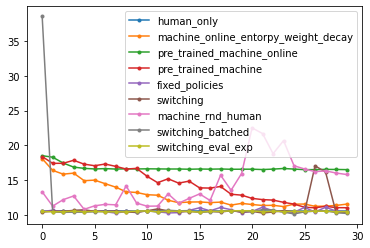

In [23]:
import pandas as pd

df = pd.DataFrame(algos)
df.plot(style='.-')


<AxesSubplot:>

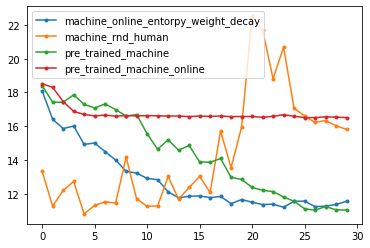

In [7]:
df[['machine_online_entorpy_weight_decay','machine_rnd_human','pre_trained_machine','pre_trained_machine_online']].plot(style='.-')


<AxesSubplot:>

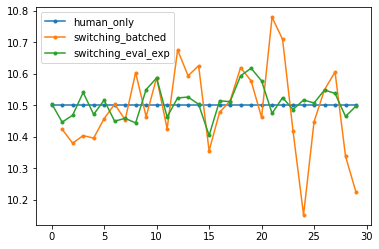

In [25]:
df[['human_only','switching','switching_eval_exp']][df<11.3].plot(style='.-')


<AxesSubplot:>

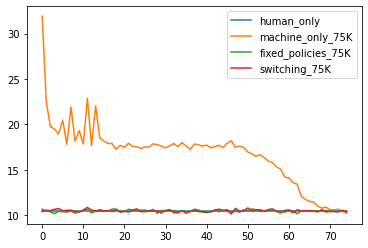

In [23]:
import pandas as pd
df_75 = pd.DataFrame(algos_75K)
df_75.plot()

<AxesSubplot:>

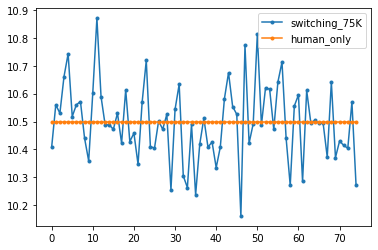

In [18]:
df_75[['switching_75K', 'human_only']].plot(style='.-')


<AxesSubplot:>

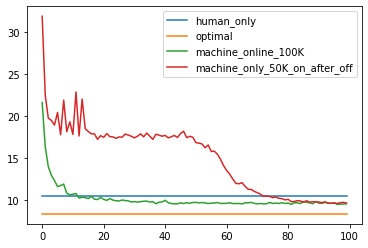

In [32]:
df_100 = pd.DataFrame(algos_100K)
df_100.plot(style='-')

# Playground

In [3]:
from environments.utils_env import difficult_grid
grid = env_generator.generate_grid_world( width, height, init_traffic_level, lambda c,s,f: difficult_grid(c,s,f,'car'), depth)

plt_path = PlotPath(grid, n_try=1)
plt_path.plot(f'{ROOT_DIR}/outputs/env_dif.png')

In [6]:
from plot.plot_path import PlotPath
from experiments.utils import *
grid_world = env_generator().generate_grid_world()
plt_path = PlotPath(grid_world, n_try=1)
# plt_path1 = PlotPath(gird_world, n_try=1)


cost = grid_world.plot_trajectory(switch_full, [human, machine], plt_path, show_cf=True)
# cost = learn_evaluate(fully_automated, [human, machine] ,gird_world , 
# is_learn=False, plt_path = plt_path, machine_only=True)

# cost1 = learn_evaluate(f_a, [human,  switch_machine] ,gird_world ,
# is_learn=False, plt_path = plt_path1)

plt_path.plot('../machine_only_light.png')
# plt_path1.plot('../machine_dummy_only_light.png')

print(cost)

(33.8, 1.0)


In [7]:
from plot.plot_path import PlotPath
from experiments.utils import *
grid = eval_set[4]
plt_path = PlotPath(grid, n_try=1)
optimal = OptimalAgent(grid, 0.2)
cost  = optimal.eval(plt_path=plt_path)
plt_path.plot('../eval_set_light.png')

print(cost)

11.799999999999997


In [33]:
optimal_costs = [ OptimalAgent(grid, 0.2).eval() for grid in eval_set]
print(np.mean(optimal_costs))

8.371999999999998


In [10]:
optimal_costs = [ OptimalAgent(grid, 0.0).eval() for grid in eval_set]
print(np.mean(optimal_costs))

4.572


In [14]:
root_dir = ROOT_DIR+'/outputs/results'
estimation_noise = 2.6
switching_noise = 0.0
n_traj = 150000
dir = root_dir+'/switch1_b1_We_off_D150K_on_D100K_e3_h2.6'
with open(f'{dir}/switching_agent_on', 'rb') as file:
    switch_full = pickle.load(file)
with open(f'{dir}/actor_agent_on', 'rb') as file:
    switch_machine = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/trajectories/human1_{estimation_noise}_{switching_noise}_light_trajectories_{n_traj}_agent_pureState', 'rb') as file:
    human = pickle.load(file)

In [112]:
cost_difference = [ OptimalAgent(grid, 0.0).eval() - evaluate(human_only, [human], [grid], 1 )[0] for grid in eval_set]

In [113]:
cost_difference = np.array(cost_difference)
ind = np.argsort(cost_difference)[:20]
grids_to_plot = np.array(eval_set)[ind]

In [15]:
for i,grid in enumerate(eval_set[:50]):
    plt_path = PlotPath(grid, n_try=1)
    cost = grid.plot_trajectory(switch_full, [human, switch_machine], plt_path, show_cf=False)
    # c_h = grid.plot_trajectory(human_only, [human_perf], plt_path, show_cf=False)
    plt_path.plot(f'{root_dir}/grid_switch1_Norm_{i}.png')

In [22]:
res = []
for _ in range(10):
    is_better = 0
    for i in range(100):
        gird_world = env_generator_fn()
        cost = learn_evaluate(fully_automated, [human, machine] ,gird_world , 
        is_learn=False, plt_path = plt_path, machine_only=True)

        cost1 = learn_evaluate(f_a, [human,  switch_machine] ,gird_world , 
        is_learn=False, plt_path = plt_path1)

        is_better+= (cost1 >= cost)

    print(is_better/100)
    res.append(is_better/100)
    print(cost, cost1)
print(np.mean(res))

0.51
27.799999999999997 35.800000000000004
0.59
17.799999999999997 19.799999999999994
0.45
27.79999999999999 31.799999999999994
0.46
39.80000000000002 41.800000000000004
0.57
35.8 17.799999999999997
0.46
61.800000000000026 63.80000000000001
0.47
21.799999999999997 41.8
0.39
21.79999999999999 15.799999999999997
0.54
41.8 47.8
0.55
9.799999999999999 21.799999999999994
0.499


10000 off 15000 on
0.56
0.46
0.47
0.55
0.52
0.55
0.51
0.44
0.57
0.6
0.523

In [8]:
from copy import deepcopy
import torch
a = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=0.2)
b = deepcopy(a)
torch.all(list(switch_machine.network.parameters())[0] == list(machine.network.parameters())[0])

tensor(False)

In [24]:
(list(machine.network.parameters())[3]).grad

tensor([4.2675e-14, 0.0000e+00, 2.3021e-14])

In [21]:
list(switch_machine.network.parameters())[3],list(machine.network.parameters())[3].grad

(Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 tensor([-7.8448e-18,  0.0000e+00,  1.1218e-24]))